##A. Housing Price Analysis and Prediction
#1. Pengaturan dan Pemuatan Data

In [2]:
# Upload dataset
from google.colab import files
uploaded = files.upload()

Saving test.csv to test.csv
Saving train.csv to train.csv


In [5]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import json
import math

# Machine learning libraries
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline

# Visualization settings
plt.style.use('fivethirtyeight')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

In [6]:
# Load the datasets
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

# Check basic information
print(f"Training set shape: {train_df.shape}")
print(f"Test set shape: {test_df.shape}")

# Create a copy of the original data for later reference
train_original = train_df.copy()
test_original = test_df.copy()

# Extract target variable
y_train = train_df['SalePrice']
X_train = train_df.drop('SalePrice', axis=1)

Training set shape: (1460, 81)
Test set shape: (1459, 80)


### Memahami Struktur Dataset

Dataset **train** memiliki 1460 baris dan 81 kolom, sedangkan dataset **test** memiliki 1459 baris dan 80 kolom. Satu-satunya perbedaan adalah kolom **'SalePrice'** pada dataset *train*, yang merupakan target prediksi untuk dataset *test*.

Kedua dataset memiliki fitur-fitur yang sama yang menggambarkan berbagai aspek rumah tinggal, termasuk:

- Atribut dasar rumah (ukuran, jumlah kamar, dll.)
- Penilaian kualitas untuk berbagai komponen rumah
- Informasi lokasi
- Data terkait tahun (tahun dibangun, direnovasi, dijual)
- Beragam fitur kategori

🎯 **Tujuan:** Membangun model yang dapat memprediksi harga rumah secara akurat berdasarkan fitur-fitur tersebut.


#2. Analisis Data Eksploratif (EDA)

In [7]:
# Check for missing values
train_missing = X_train.isnull().sum()[X_train.isnull().sum() > 0].sort_values(ascending=False)
test_missing = test_df.isnull().sum()[test_df.isnull().sum() > 0].sort_values(ascending=False)

print("Missing values in training data:")
print(train_missing)

print("\nMissing values in test data:")
print(test_missing)

# Check data types
print("\nData types in training set:")
print(X_train.dtypes.value_counts())

# Basic summary statistics
numeric_columns = X_train.select_dtypes(include=['int64', 'float64']).columns
train_numeric_summary = X_train[numeric_columns].describe()

# Convert to JSON for requested format
train_numeric_json = json.loads(train_numeric_summary.to_json(orient='split'))
print("\nNumeric features summary (JSON format):")
print(json.dumps(train_numeric_json, indent=2)[:1000] + "...")

Missing values in training data:
PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
MasVnrType       872
FireplaceQu      690
LotFrontage      259
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
BsmtExposure      38
BsmtFinType2      38
BsmtQual          37
BsmtCond          37
BsmtFinType1      37
MasVnrArea         8
Electrical         1
dtype: int64

Missing values in test data:
PoolQC          1456
MiscFeature     1408
Alley           1352
Fence           1169
MasVnrType       894
FireplaceQu      730
LotFrontage      227
GarageQual        78
GarageCond        78
GarageYrBlt       78
GarageFinish      78
GarageType        76
BsmtCond          45
BsmtQual          44
BsmtExposure      44
BsmtFinType1      42
BsmtFinType2      42
MasVnrArea        15
MSZoning           4
Functional         2
BsmtFullBath       2
Utilities          2
BsmtHalfBath       2
Exterior1st        1
Exterior2nd        1


Memahami Nilai yang Hilang
Nilai yang hilang dalam dataset dapat menimbulkan bias dan memengaruhi kinerja model. Terdapat beberapa jenis data yang hilang:

1. Missing Completely at Random (MCAR): Probabilitas nilai hilang adalah sama untuk semua observasi.

2. Missing at Random (MAR): Probabilitas nilai hilang bergantung pada data yang terlihat (yang diamati).

3. Missing Not at Random (MNAR): Probabilitas nilai hilang bergantung pada data yang tidak terlihat (yang tidak diamati).

Untuk dataset perumahan kita, banyak nilai yang hilang menunjukkan ketidakhadiran suatu fitur (seperti tidak adanya kolam renang, garasi, atau basement). Kita perlu menangani hal ini dengan tepat saat melakukan rekayasa fitur (feature engineering).

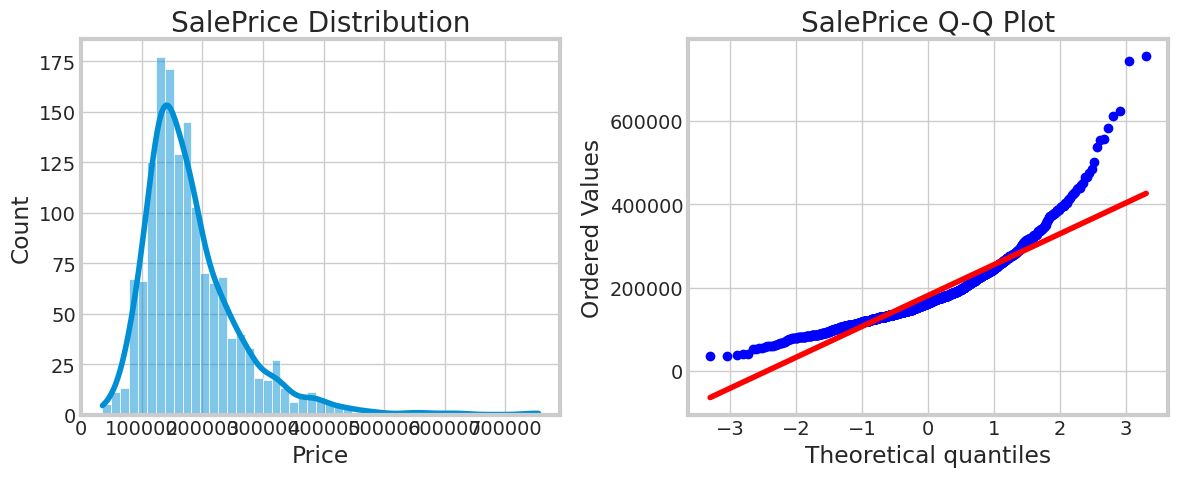

SalePrice Statistics (JSON format):
{
  "mean": 180921.19589041095,
  "median": 163000.0,
  "std": 79442.50288288663,
  "min": 34900,
  "max": 755000,
  "skewness": 1.8828757597682129,
  "kurtosis": 6.536281860064529
}


In [8]:
# Analyze the target variable (SalePrice)
plt.figure(figsize=(12, 5))

# Distribution plot
plt.subplot(1, 2, 1)
sns.histplot(y_train, kde=True)
plt.title('SalePrice Distribution')
plt.xlabel('Price')

# Q-Q plot
plt.subplot(1, 2, 2)
stats.probplot(y_train, plot=plt)
plt.title('SalePrice Q-Q Plot')

plt.tight_layout()
plt.show()

# Calculate key statistics for SalePrice
saleprice_stats = {
    "mean": y_train.mean(),
    "median": y_train.median(),
    "std": y_train.std(),
    "min": y_train.min(),
    "max": y_train.max(),
    "skewness": y_train.skew(),
    "kurtosis": y_train.kurt()
}

print("SalePrice Statistics (JSON format):")
print(json.dumps(saleprice_stats, indent=2))

Distribusi SalePrice: Penjelasan Matematis
Distribusi SalePrice menunjukkan kemencengan ke kanan (right-skewness), yang umum terjadi pada data keuangan seperti harga. Mari kita pahami beberapa ukuran statistik berikut:

# Kemencengan (Skewness):

> $Skewness = \frac{\sum_{i=1}^{n} (x_i - \bar{x})^3 / n}{s^3}$

=> Di mana $\bar{x}$ adalah rata-rata, $s$ adalah simpangan baku, dan $n$ adalah jumlah observasi

=> Kemencengan positif menunjukkan distribusi menceng ke kanan (ekor panjang di kanan)

=> Kemencengan negatif menunjukkan distribusi menceng ke kiri (ekor panjang di kiri)

=> Nilai > 1 atau < -1 menunjukkan distribusi yang sangat menceng (highly skewed)

# Kurtosis:

> $Kurtosis = \frac{\sum_{i=1}^{n} (x_i - \bar{x})^4 / n}{s^4} - 3$

=> Mengukur seberapa "tebal" ekor distribusi (tailedness)

=> Kurtosis positif menunjukkan ekor berat (leptokurtik)

=> Kurtosis negatif menunjukkan ekor ringan (platykurtik)

=> Pengurangan 3 membuat kurtosis distribusi normal menjadi 0

Untuk SalePrice, kemencengan positif menyarankan bahwa kita mungkin perlu melakukan transformasi logaritmik agar distribusinya lebih mendekati normal. Hal ini dapat membantu banyak algoritma machine learning bekerja lebih baik.

Top 10 positive correlations with SalePrice:
{"OverallQual":0.7909816006,"GrLivArea":0.7086244776,"GarageCars":0.6404091973,"GarageArea":0.6234314389,"TotalBsmtSF":0.6135805516,"1stFlrSF":0.6058521847,"FullBath":0.5606637627,"TotRmsAbvGrd":0.5337231556,"YearBuilt":0.5228973329,"YearRemodAdd":0.5071009671}

Top 10 negative correlations with SalePrice:
{"BsmtFinSF2":-0.0113781215,"BsmtHalfBath":-0.0168441543,"MiscVal":-0.0211895796,"Id":-0.0219167194,"LowQualFinSF":-0.02560613,"YrSold":-0.0289225852,"OverallCond":-0.077855894,"MSSubClass":-0.0842841351,"EnclosedPorch":-0.1285779579,"KitchenAbvGr":-0.1359073708}


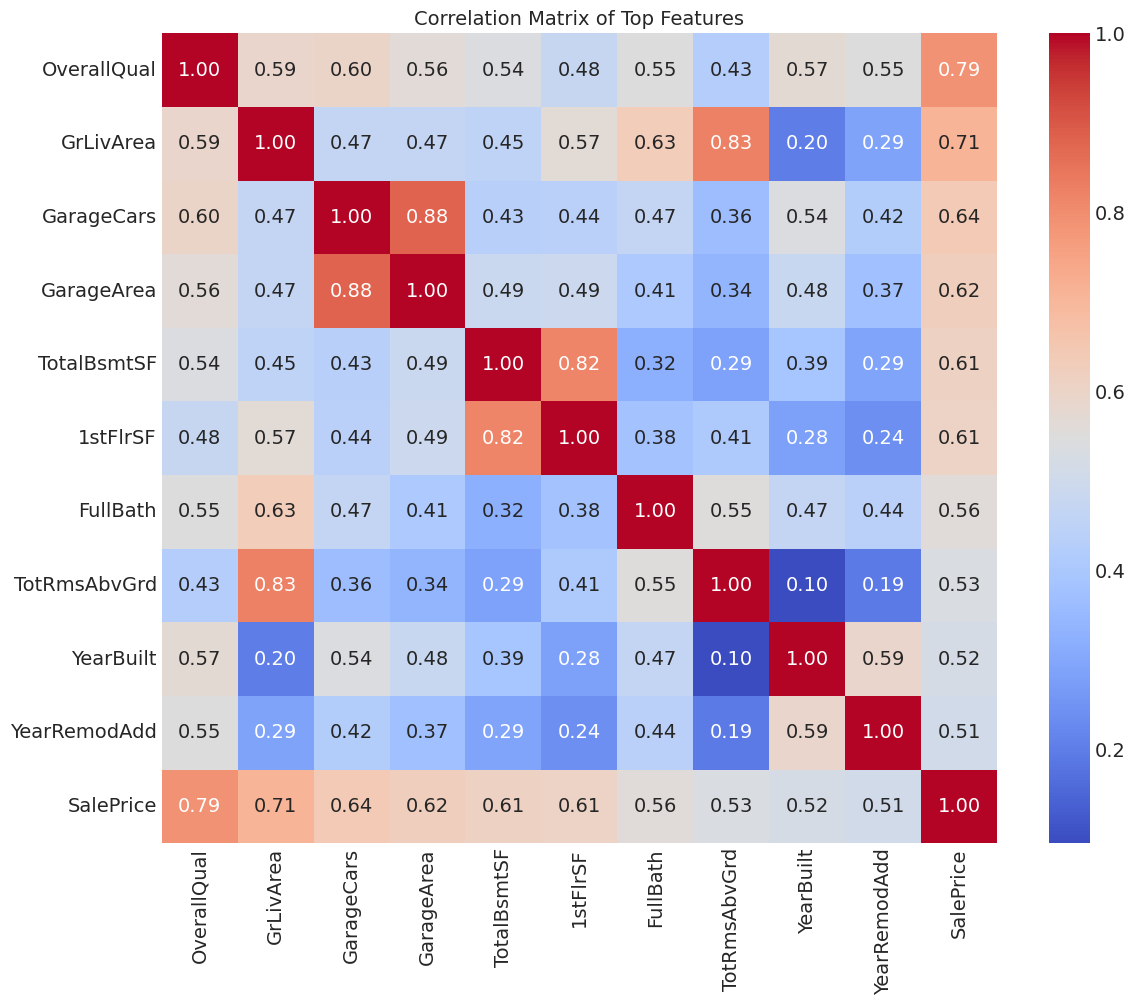


Correlation matrix (JSON format):
{
  "OverallQual": {
    "OverallQual": 1.0,
    "GrLivArea": 0.59300743,
    "GarageCars": 0.6006707166,
    "GarageArea": 0.5620217566,
    "TotalBsmtSF": 0.5378084986,
    "1stFlrSF": 0.4762238291,
    "FullBath": 0.5505997094,
    "TotRmsAbvGrd": 0.4274523433,
    "YearBuilt": 0.572322769,
    "YearRemodAdd": 0.5506839242,
    "SalePrice": 0.7909816006
  },
  "GrLivArea": {
    "OverallQual": 0.59300743,
    "GrLivArea": 1.0,
    "GarageCars": 0.4672474188,
    "GarageArea": 0.4689974773,
    "TotalBsmtSF": 0.4548682025,
    "1stFlrSF": 0.5660239689,
    "FullBath": 0.6300116463,
    "TotRmsAbvGrd": 0.8254893743,
    "YearBuilt": 0.1990097137,
    "YearRemodAdd": 0.2873885197,
    "SalePrice": 0.7086244776
  },
  "GarageCars": {
    "OverallQual": 0.6006707166,
    "GrLivArea": 0.4672474188,
    "GarageCars": 1.0,
    "GarageArea": 0.8824754143,
    "TotalBsmtSF": 0.4345848343,
    "1stFlrSF": 0.439316808,
    "FullBath": 0.4696720433,
    "TotRms

In [9]:
# Calculate correlations with SalePrice
correlations = X_train[numeric_columns].corrwith(y_train).sort_values(ascending=False)

# Display top positive and negative correlations
print("Top 10 positive correlations with SalePrice:")
print(correlations.head(10).to_json())

print("\nTop 10 negative correlations with SalePrice:")
print(correlations.tail(10).to_json())

# Correlation matrix for visualization
top_corr_features = correlations.abs().sort_values(ascending=False).head(10).index
correlation_matrix = train_df[list(top_corr_features) + ['SalePrice']].corr()

# Visualize correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Top Features', fontsize=14)
plt.show()

# Convert correlation matrix to JSON format
corr_matrix_json = json.loads(correlation_matrix.to_json())
print("\nCorrelation matrix (JSON format):")
print(json.dumps(corr_matrix_json, indent=2)[:1000] + "...")

# Analisis Korelasi: Penjelasan Matematis
Korelasi mengukur hubungan linear antara dua variabel. Koefisien korelasi Pearson dihitung dengan rumus:

$$r = \frac{\sum_{i=1}^{n} (x_i - \bar{x})(y_i - \bar{y})}{\sqrt{\sum_{i=1}^{n} (x_i - \bar{x})^2 \sum_{i=1}^{n} (y_i - \bar{y})^2}}$$

=> $x_i$ dan $y_i$ adalah nilai dari masing-masing variabel

=> $\bar{x}$ dan $\bar{y}$ adalah dalah nilai rata-rata dari variabel tersebut

=> $n$ adalah jumlah observasi

Nilai koefisien korelasi berkisar dari -1 hingga 1:

=> 1: Korelasi positif sempurna

=> 0: Tidak ada korelasi linear

=> -1: Korelasi negatif sempurna

Interpretasi matriks korelasi:

=> Korelasi positif yang kuat dengan SalePrice menunjukkan bahwa ketika fitur tersebut meningkat, harga rumah cenderung meningkat juga

=> Korelasi negatif yang kuat menunjukkan bahwa ketika fitur tersebut meningkat, harga rumah cenderung menurun

=> Fitur dengan korelasi mendekati 0 memiliki hubungan linear yang lemah dengan harga

🔎 Perlu diingat: korelasi hanya menangkap hubungan linear. Bisa saja terdapat hubungan non-linear yang tidak terlihat melalui pengukuran ini.

Number of categorical features: 43
Categorical features: ['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']



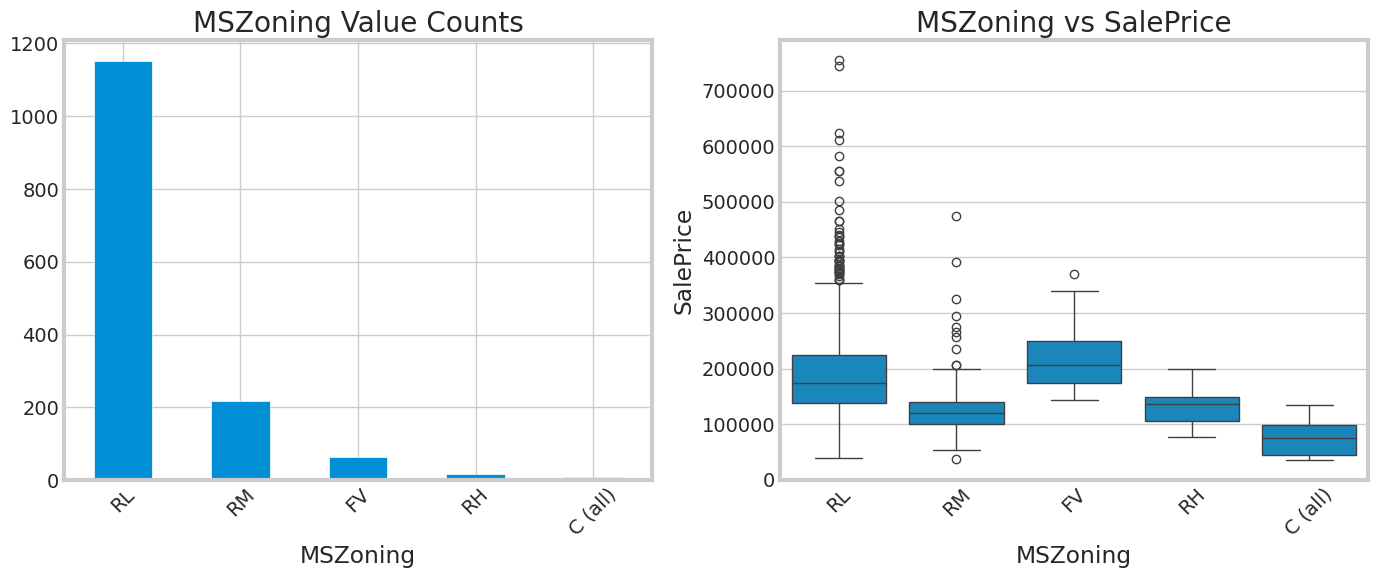

MSZoning value counts (JSON format):
{
  "RL": 1151,
  "RM": 218,
  "FV": 65,
  "RH": 16,
  "C (all)": 10
}


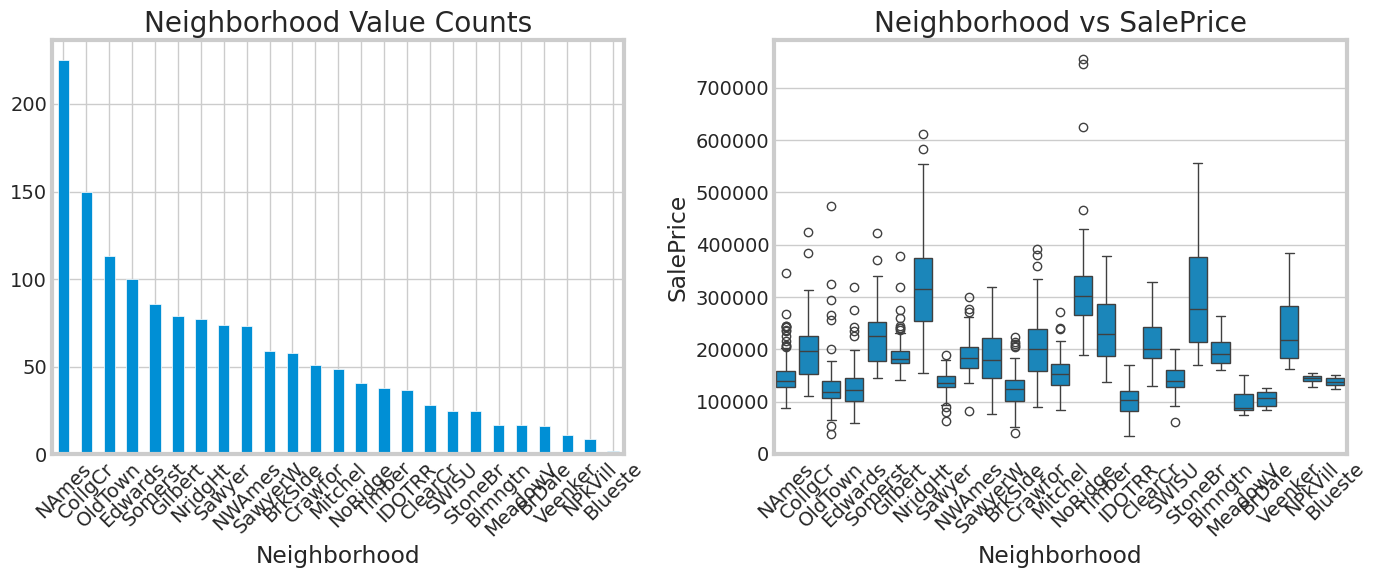

Neighborhood value counts (JSON format):
{
  "NAmes": 225,
  "CollgCr": 150,
  "OldTown": 113,
  "Edwards": 100,
  "Somerst": 86,
  "Gilbert": 79,
  "NridgHt": 77,
  "Sawyer": 74,
  "NWAmes": 73,
  "SawyerW": 59,
  "BrkSide": 58,
  "Crawfor": 51,
  "Mitchel": 49,
  "NoRidge": 41,
  "Timber": 38,
  "IDOTRR": 37,
  "ClearCr": 28,
  "SWISU": 25,
  "StoneBr": 25,
  "Blmngtn": 17,
  "MeadowV": 17,
  "BrDale": 16,
  "Veenker": 11,
  "NPkVill": 9,
  "Blueste": 2
}


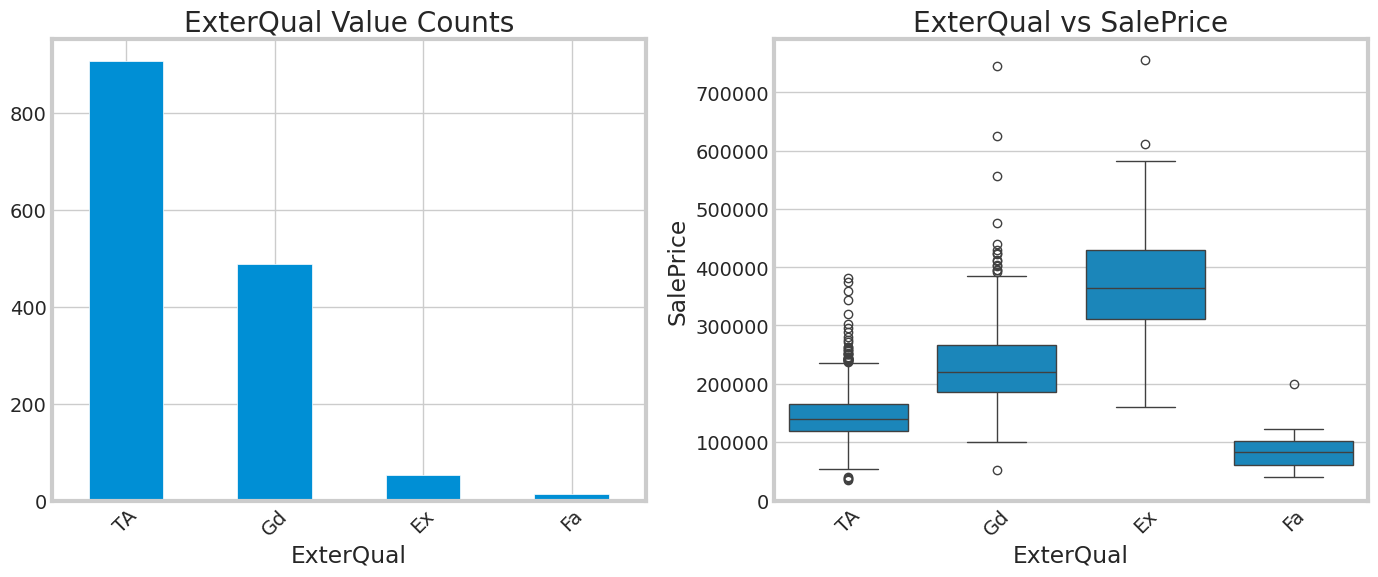

ExterQual value counts (JSON format):
{
  "TA": 906,
  "Gd": 488,
  "Ex": 52,
  "Fa": 14
}


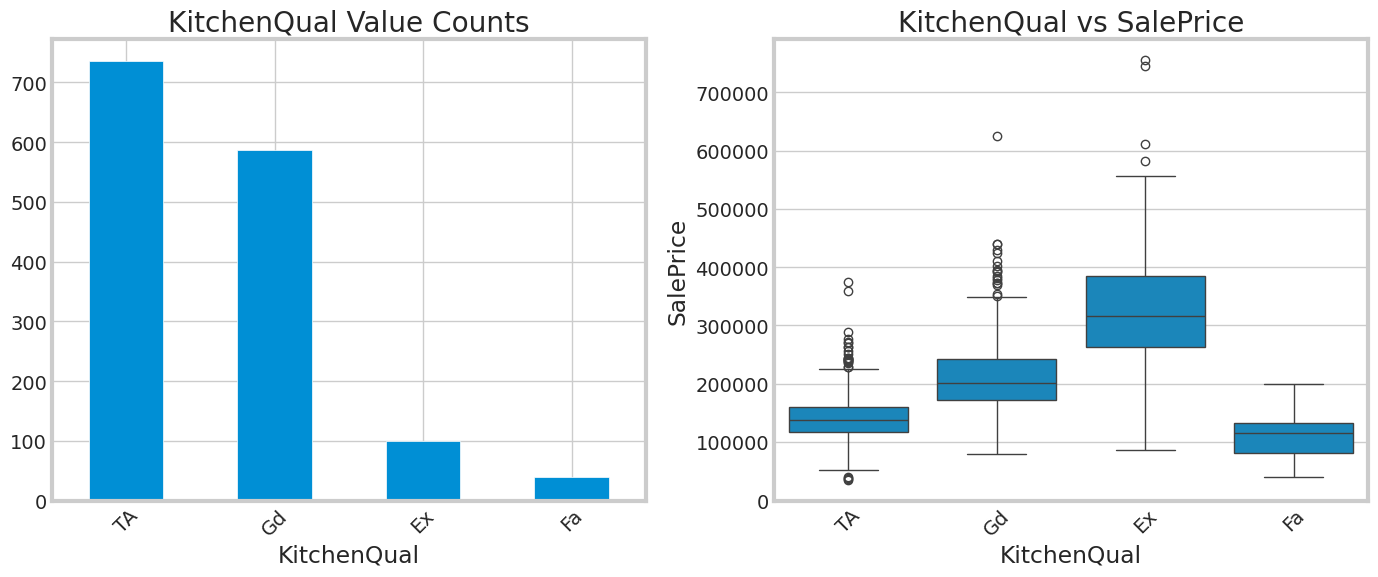

KitchenQual value counts (JSON format):
{
  "TA": 735,
  "Gd": 586,
  "Ex": 100,
  "Fa": 39
}


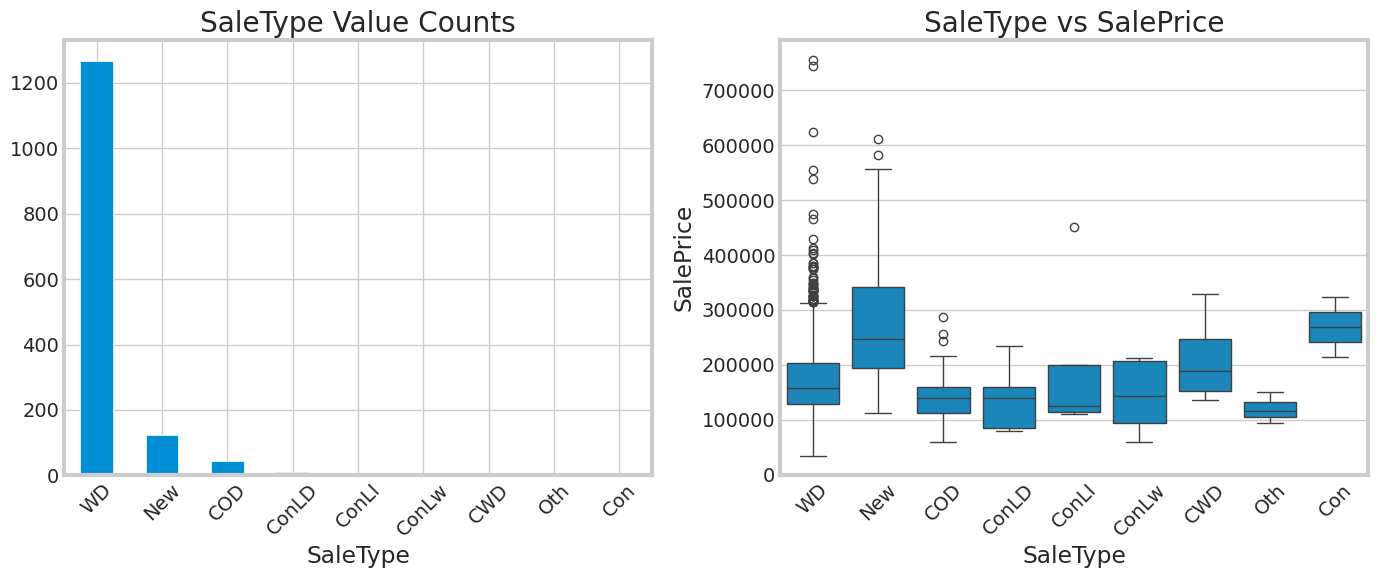

SaleType value counts (JSON format):
{
  "WD": 1267,
  "New": 122,
  "COD": 43,
  "ConLD": 9,
  "ConLI": 5,
  "ConLw": 5,
  "CWD": 4,
  "Oth": 3,
  "Con": 2
}


In [10]:
# Analyze categorical features
categorical_cols = X_train.select_dtypes(include=['object']).columns
print(f"Number of categorical features: {len(categorical_cols)}")
print(f"Categorical features: {list(categorical_cols)}\n")

# Analyze key categorical variables
important_categorical = ['MSZoning', 'Neighborhood', 'ExterQual', 'KitchenQual', 'SaleType']

for feature in important_categorical:
    # Value counts
    value_counts = X_train[feature].value_counts()

    # Boxplot to see relationship with price
    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    value_counts.plot(kind='bar')
    plt.title(f'{feature} Value Counts')
    plt.xticks(rotation=45)

    plt.subplot(1, 2, 2)
    order = value_counts.index
    sns.boxplot(x=feature, y='SalePrice', data=train_df, order=order)
    plt.title(f'{feature} vs SalePrice')
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

    # JSON format of value counts
    counts_json = json.loads(value_counts.to_json())
    print(f"{feature} value counts (JSON format):")
    print(json.dumps(counts_json, indent=2))

#3. Feature Engineering (Rekayasa Fitur)
Feature engineering adalah proses membuat fitur baru atau mengubah fitur yang sudah ada untuk meningkatkan performa model. Langkah ini sering menjadi salah satu bagian terpenting dalam proses machine learning.

Kita akan menerapkan beberapa teknik feature engineering berikut:

=> Menangani nilai yang hilang

=> Transformasi logaritmik pada fitur yang menceng (skewed)

=> Mengubah fitur kategorikal menjadi numerik

=> Membuat fitur baru

=> Melakukan penskalaan fitur (feature scaling)

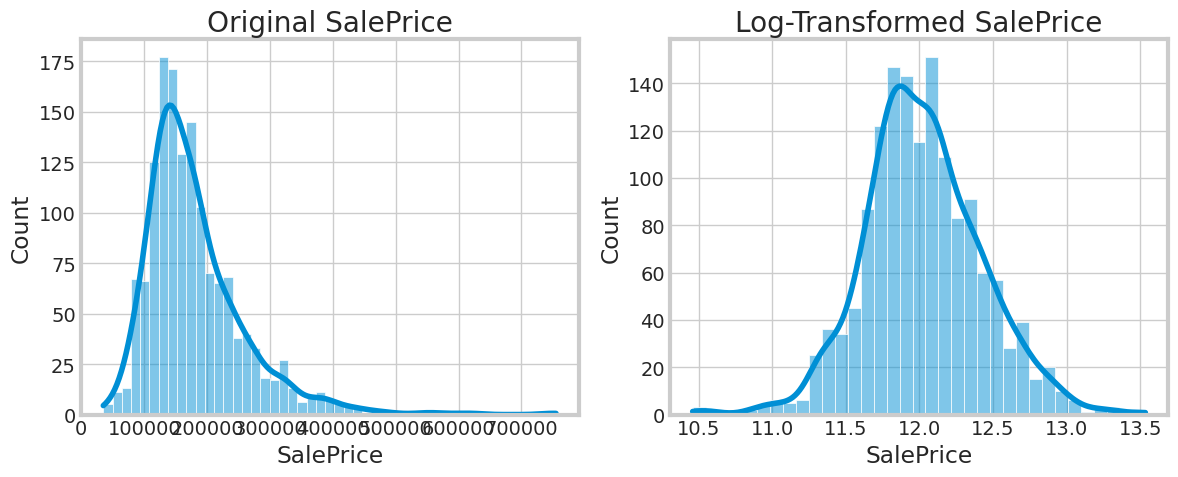

Log-transformed SalePrice statistics (JSON format):
{
  "mean": 12.024057394918406,
  "median": 12.001511614739405,
  "std": 0.3994492733225068,
  "skewness": 0.12134661989685333,
  "kurtosis": 0.809519155707878
}


In [11]:
# Apply log transformation to SalePrice
y_train_log = np.log1p(y_train)

# Compare original and transformed distributions
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(y_train, kde=True)
plt.title('Original SalePrice')

plt.subplot(1, 2, 2)
sns.histplot(y_train_log, kde=True)
plt.title('Log-Transformed SalePrice')

plt.tight_layout()
plt.show()

# Calculate statistics for transformed SalePrice
log_saleprice_stats = {
    "mean": y_train_log.mean(),
    "median": y_train_log.median(),
    "std": y_train_log.std(),
    "skewness": y_train_log.skew(),
    "kurtosis": y_train_log.kurt()
}

print("Log-transformed SalePrice statistics (JSON format):")
print(json.dumps(log_saleprice_stats, indent=2))

#Transformasi Logaritmik: Penjelasan Matematis
Transformasi logaritmik umum digunakan untuk data yang menceng ke kanan seperti harga. Kita menggunakan logaritma natural (basis e) ditambah 1 untuk menangani nilai nol.

Rumus: $y_{\text{transformed}} = \log(y + 1)$

Sifat Matematis:

=> Menekan nilai yang besar lebih kuat dibanding nilai kecil

=> Mengurangi kemencengan ke kanan

=> Mengubah hubungan perkalian menjadi penjumlahan

=> Menstabilkan varians

Mengapa kita menambahkan 1 (log1p):

=> Menghindari log(0) yang tidak terdefinisi

=> Untuk nilai kecil, log(1 + x) ≈ x, sehingga skala relatif tetap terjaga

Dalam interpretasi koefisien model dengan transformasi log:

=> Peningkatan satu unit pada suatu fitur berhubungan dengan persentase perubahan pada target asli

=> Untuk memprediksi harga asli, kita gunakan transformasi balik: $\exp(\hat{y}) - 1$

Seperti yang dapat kita lihat dari histogram dan statistik, transformasi log telah secara signifikan mengurangi kemencengan dari variabel target, sehingga distribusinya menjadi lebih mendekati normal.

In [12]:
# Combine train and test data for consistent preprocessing
# Note: We'll keep the log-transformed target variable separate
all_features = pd.concat([X_train, test_df], axis=0)
print(f"Combined features shape: {all_features.shape}")

# Handle missing values
# We'll use different strategies for different features

# 1. Numerical features with missing values
numeric_with_na = [col for col in numeric_columns if all_features[col].isnull().sum() > 0]
print(f"\nNumerical features with missing values: {numeric_with_na}")

# For most numerical features, use median imputation
for col in numeric_with_na:
    # LotFrontage: can be imputed based on neighborhood and lot size
    if col == 'LotFrontage':
        all_features['LotFrontage'] = all_features.groupby('Neighborhood')['LotFrontage'].transform(
            lambda x: x.fillna(x.median())
        )
    # For others, simple median imputation
    else:
        all_features[col].fillna(all_features[col].median(), inplace=True)

# 2. Categorical features with missing values
categorical_with_na = [col for col in categorical_cols if all_features[col].isnull().sum() > 0]
print(f"\nCategorical features with missing values: {categorical_with_na}")
# For most categorical features, NA means feature doesn't exist
for col in categorical_with_na:
    # For features where NA means feature doesn't exist
    if col in ['Alley', 'PoolQC', 'Fence', 'MiscFeature', 'FireplaceQu',
               'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
               'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
               'MasVnrType']:
        all_features[col].fillna('None', inplace=True)
    # For others, use mode (most frequent value)
    else:
        all_features[col].fillna(all_features[col].mode()[0], inplace=True)

# Check if any missing values remain
remaining_na = all_features.isnull().sum().sum()
print(f"\nRemaining missing values: {remaining_na}")

# Format missing value handling as JSON
missing_handling = {
    "numerical_features": {
        "LotFrontage": "Median by neighborhood",
        "other_features": "Median imputation"
    },
    "categorical_features": {
        "features_with_None": ["Alley", "PoolQC", "Fence", "MiscFeature", "FireplaceQu",
                             "GarageType", "GarageFinish", "GarageQual", "GarageCond",
                             "BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1", "BsmtFinType2",
                             "MasVnrType"],
        "other_features": "Mode imputation"
    }
}

print("\nMissing value handling (JSON format):")
print(json.dumps(missing_handling, indent=2))

Combined features shape: (2919, 80)

Numerical features with missing values: ['LotFrontage', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'GarageYrBlt', 'GarageCars', 'GarageArea']

Categorical features with missing values: ['MSZoning', 'Alley', 'Utilities', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType']

Remaining missing values: 0

Missing value handling (JSON format):
{
  "numerical_features": {
    "LotFrontage": "Median by neighborhood",
    "other_features": "Median imputation"
  },
  "categorical_features": {
    "features_with_None": [
      "Alley",
      "PoolQC",
      "Fence",
      "MiscFeature",
      "FireplaceQu",
      "GarageType",
      "GarageFinish",
      "GarageQual",
      "Garag

#Imputasi Nilai yang Hilang: Penjelasan Matematis
Imputasi nilai yang hilang adalah langkah praproses yang sangat penting. Terdapat berbagai strategi, masing-masing dengan implikasi matematis:

Imputasi Median:

=> Mengganti nilai yang hilang dengan median kolom

=> Rumus:  $x_{imputed} = median(\{x_i | x_i \text{ tidak hilang}\})$

=> Lebih tahan terhadap outlier dibanding imputasi rata-rata

=> Mempertahankan kecenderungan pusat dari distribusi

=> Tidak memengaruhi nilai median dari distribusi secara keseluruhan

Imputasi Mean (Rata-rata):

=> Mengganti nilai yang hilang dengan rata-rata kolom

=> Rumus: $x_{imputed} = \frac{1}{n} \sum_{i=1}^{n} x_i$ dimana $x_i$ tidak hilang

=> Sederhana tetapi sensitif terhadap outlier

=> Dapat mengurangi varians data

Imputasi Modus (untuk variabel kategorikal):

=> Mengganti nilai yang hilang dengan kategori yang paling sering muncul

=> Mempertahankan nilai modus distribusi

=> Cocok untuk variabel kategorikal nominal

Imputasi Berdasarkan Kelompok (Group-based Imputation):

=> Menggunakan statistik berdasarkan kelompok untuk mengisi nilai yang hilang (misalnya median per lingkungan)

=> Lebih mendetail dibanding imputasi global

=> Memperhitungkan pola dalam data

Rumus: $x_{imputed} = median(\{x_i | x_i \text{ berada di grup yang sama dan tidak hilang}\})$

Imputasi dengan Nilai Konstan ("None"):

=> Digunakan ketika nilai hilang berarti fitur tersebut tidak ada

=> Membuat kategori baru untuk kasus ini

=> Menjaga makna semantik dari “ketidakhadiran” fitur

Setiap strategi imputasi memengaruhi distribusi data secara berbeda dan dapat menimbulkan bias jika mekanisme hilangnya data tidak benar-benar acak.

In [13]:
# Transform skewed numerical features
numeric_features = all_features.select_dtypes(include=['int64', 'float64']).columns

# Calculate skewness
skewed_features = all_features[numeric_features].apply(lambda x: stats.skew(x.dropna()))
high_skew_features = skewed_features[skewed_features > 0.5].index

print(f"Number of highly skewed features: {len(high_skew_features)}")
print(f"Highly skewed features: {list(high_skew_features)[:5]}...")

# Apply log transformation to highly skewed features
for feature in high_skew_features:
    # Add a small constant (1) to handle zeros
    all_features[feature] = np.log1p(all_features[feature])

# Check skewness after transformation
after_transform_skew = all_features[high_skew_features].apply(lambda x: stats.skew(x.dropna()))

# Compare before and after
skew_comparison = pd.DataFrame({
    'before_transform': skewed_features[high_skew_features],
    'after_transform': after_transform_skew
})

print("\nSkewness before and after transformation (first 5 features):")
print(skew_comparison.head().to_string())

# Format as JSON
skew_json = json.loads(skew_comparison.to_json(orient='index'))
print("\nSkewness comparison (JSON format):")
print(json.dumps(skew_json, indent=2)[:500] + "...")

Number of highly skewed features: 26
Highly skewed features: ['MSSubClass', 'LotFrontage', 'LotArea', 'OverallCond', 'MasVnrArea']...

Skewness before and after transformation (first 5 features):
             before_transform  after_transform
MSSubClass           1.375457         0.245157
LotFrontage          1.505704        -1.023606
LotArea             12.822431        -0.504751
OverallCond          0.570312        -0.746183
MasVnrArea           2.613592         0.537018

Skewness comparison (JSON format):
{
  "MSSubClass": {
    "before_transform": 1.3754573603,
    "after_transform": 0.2451574794
  },
  "LotFrontage": {
    "before_transform": 1.5057038424,
    "after_transform": -1.0236060651
  },
  "LotArea": {
    "before_transform": 12.8224314016,
    "after_transform": -0.5047505513
  },
  "OverallCond": {
    "before_transform": 0.5703120503,
    "after_transform": -0.7461828792
  },
  "MasVnrArea": {
    "before_transform": 2.6135921295,
    "after_transform": 0.5370181912
 

#Transformasi Fitur untuk Data yang Miring: Penjelasan Matematis
Skewness (kemiringan) mengukur tingkat ketidaksimetrian dari suatu distribusi. Nilainya dihitung menggunakan momen standar ketiga:

$$Skewness = \frac{E[(X-\mu)^3]}{\sigma^3} = \frac{\sum_{i=1}^{n} (x_i - \bar{x})^3 / n}{(\sum_{i=1}^{n} (x_i - \bar{x})^2 / n)^{3/2}}$$

Dimana:

=> $\mu$ adalah rata-rata (mean)

=> $\sigma$ adalah simpangan baku (standard deviation)

=> $E[]$ menyatakan nilai harapan (expected value)

Interpretasi:

=> Skewness > 0: Miring ke kanan (skew positif)

=> Skewness < 0: Miring ke kiri (skew negatif)

=> Skewness = 0: Simetris (seperti distribusi normal)

Mengapa perlu mentransformasi fitur yang miring?

1) Banyak model statistik mengasumsikan data terdistribusi normal

2) Data yang miring dapat mempengaruhi model secara tidak proporsional

3) Fitur dengan skala yang seragam biasanya bekerja lebih baik di banyak algoritma

Efek transformasi logaritmik:

=> Memampatkan rentang nilai yang besar

=> Memperluas rentang nilai yang kecil

=> Mengubah hubungan multiplikatif menjadi aditif

=> Rumus: $x_{transformed} = \log(x + 1)$

Untuk fitur yang sangat miring, transformasi log sering kali secara signifikan mengurangi skewness, membuat distribusi lebih simetris, dan meningkatkan performa model.

In [14]:
# Encode categorical features
# We'll use one-hot encoding for nominal features and label encoding for ordinal features

# 1. First, identify ordinal features
ordinal_features = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
                     'BsmtFinType1', 'BsmtFinType2', 'HeatingQC', 'KitchenQual',
                     'FireplaceQu', 'GarageQual', 'GarageCond', 'PoolQC']

# Define ordinal mappings
quality_mapping = {'None': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}
exposure_mapping = {'None': 0, 'No': 1, 'Mn': 2, 'Av': 3, 'Gd': 4}
fin_type_mapping = {'None': 0, 'Unf': 1, 'LwQ': 2, 'Rec': 3, 'BLQ': 4, 'ALQ': 5, 'GLQ': 6}

# Apply mappings to ordinal features
for feature in ordinal_features:
    if feature in ['BsmtExposure']:
        all_features[feature] = all_features[feature].map(exposure_mapping)
    elif feature in ['BsmtFinType1', 'BsmtFinType2']:
        all_features[feature] = all_features[feature].map(fin_type_mapping)
    else:  # Quality features
        all_features[feature] = all_features[feature].map(quality_mapping)

# 2. One-hot encode remaining nominal features
remaining_categorical = [col for col in all_features.select_dtypes(include=['object']).columns
                         if col not in ordinal_features]

print(f"Number of nominal features to one-hot encode: {len(remaining_categorical)}")
print(f"Examples: {remaining_categorical[:5]}...")

# Apply one-hot encoding
all_features_encoded = pd.get_dummies(all_features, columns=remaining_categorical, drop_first=True)
print(f"\nShape after one-hot encoding: {all_features_encoded.shape}")

# Create JSON explaining the encoding
encoding_json = {
    "ordinal_encoding": {
        "features": ordinal_features,
        "mappings": {
            "quality_features": quality_mapping,
            "exposure_features": exposure_mapping,
            "fintype_features": fin_type_mapping
        }
    },
    "one_hot_encoding": {
        "features": remaining_categorical,
        "example_transformation": "MSZoning -> MSZoning_RL, MSZoning_RM, etc."
    }
}

print("\nEncoding methods (JSON format):")
print(json.dumps(encoding_json, indent=2))

Number of nominal features to one-hot encode: 30
Examples: ['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour']...

Shape after one-hot encoding: (2919, 217)

Encoding methods (JSON format):
{
  "ordinal_encoding": {
    "features": [
      "ExterQual",
      "ExterCond",
      "BsmtQual",
      "BsmtCond",
      "BsmtExposure",
      "BsmtFinType1",
      "BsmtFinType2",
      "HeatingQC",
      "KitchenQual",
      "FireplaceQu",
      "GarageQual",
      "GarageCond",
      "PoolQC"
    ],
    "mappings": {
      "quality_features": {
        "None": 0,
        "Po": 1,
        "Fa": 2,
        "TA": 3,
        "Gd": 4,
        "Ex": 5
      },
      "exposure_features": {
        "None": 0,
        "No": 1,
        "Mn": 2,
        "Av": 3,
        "Gd": 4
      },
      "fintype_features": {
        "None": 0,
        "Unf": 1,
        "LwQ": 2,
        "Rec": 3,
        "BLQ": 4,
        "ALQ": 5,
        "GLQ": 6
      }
    }
  },
  "one_hot_encoding": {
    "features": [

Pengkodean Kategori: Penjelasan Matematis
Algoritma machine learning umumnya memerlukan input berupa nilai numerik, sehingga variabel kategorikal perlu dikodekan. Terdapat dua pendekatan utama yang biasa digunakan:

1) Ordinal Encoding (Pengkodean Ordinal):

=> Mengubah kategori menjadi bilangan bulat berdasarkan urutan alaminya

=> Representasi matematis:
$f: \{category_1, category_2, ..., category_k\} \rightarrow \{1, 2, ..., k\}$

=> Menjaga hubungan urutan antar kategori

=> Cocok untuk fitur ordinal (seperti penilaian kualitas: Buruk < Cukup < Baik < Sangat Baik)

2) One-Hot Encoding:

=> Mengubah setiap kategori menjadi fitur biner

=> Jika sebuah variabel kategorikal memiliki $k$ kategori, maka akan dibuat $k-1$ fitur biner

=> Representasi matematis: Vektor one-hot $[0, 0, ..., 1, ..., 0]$ di mana angka 1 berada di posisi yang mewakili kategori tersebut

=> Contoh: Jika variabel MSZoning memiliki kategori {RL, RM, C}, maka menjadi fitur MSZoning_RM, MSZoning_C (dengan MSZoning_RL sebagai kategori acuan)

=> Cocok untuk fitur nominal (tidak memiliki urutan bawaan)

Mengapa menggunakan drop_first=True dalam one-hot encoding?

=> Menghindari "jebakan variabel dummy" (multikolinearitas sempurna)

=> Jika terdapat $k$ kategori yang dikodekan menjadi $k$ fitur biner, maka mengetahui $k-1$ fitur sudah cukup untuk menentukan fitur terakhir

=> Secara matematis: jika $x_1, x_2, ..., x_k$ adalah indikator biner dan $\sum_{i=1}^{k} x_i = 1$, maka $x_k = 1 - \sum_{i=1}^{k-1} x_i$

=> Menghapus satu kategori (biasanya kategori pertama atau yang paling sering muncul) menyelesaikan masalah ini

=> Membantu meningkatkan stabilitas dan interpretasi model

In [15]:
# Create new engineered features

# Total square footage
all_features_encoded['TotalSF'] = all_features_encoded['TotalBsmtSF'] + all_features_encoded['1stFlrSF'] + all_features_encoded['2ndFlrSF']

# Total bathrooms
all_features_encoded['TotalBathrooms'] = (all_features_encoded['FullBath'] +
                                          (0.5 * all_features_encoded['HalfBath']) +
                                          all_features_encoded['BsmtFullBath'] +
                                          (0.5 * all_features_encoded['BsmtHalfBath']))

# House age and when remodeled
all_features_encoded['Age'] = all_features_encoded['YrSold'] - all_features_encoded['YearBuilt']
all_features_encoded['YearsSinceRemodel'] = all_features_encoded['YrSold'] - all_features_encoded['YearRemodAdd']

# Create a ratio of Above Ground Living Area to lot size
all_features_encoded['LivingAreaRatio'] = all_features_encoded['GrLivArea'] / all_features_encoded['LotArea']

# Has pool, garage, basement, etc.
all_features_encoded['HasPool'] = (all_features_encoded['PoolArea'] > 0).astype(int)
all_features_encoded['HasGarage'] = (all_features_encoded['GarageArea'] > 0).astype(int)
all_features_encoded['HasBasement'] = (all_features_encoded['TotalBsmtSF'] > 0).astype(int)
all_features_encoded['HasDeck'] = (all_features_encoded['WoodDeckSF'] > 0).astype(int)
all_features_encoded['HasPorch'] = ((all_features_encoded['OpenPorchSF'] +
                                    all_features_encoded['EnclosedPorch'] +
                                    all_features_encoded['3SsnPorch'] +
                                    all_features_encoded['ScreenPorch']) > 0).astype(int)
# Overall living quality
all_features_encoded['OverallGrade'] = all_features_encoded['OverallQual'] * all_features_encoded['OverallCond']

# List new features
new_features = ['TotalSF', 'TotalBathrooms', 'Age', 'YearsSinceRemodel', 'LivingAreaRatio',
                'HasPool', 'HasGarage', 'HasBasement', 'HasDeck', 'HasPorch', 'OverallGrade']

print("New engineered features:")
for feature in new_features:
    print(f"- {feature}")

# Create JSON for feature engineering
feature_engineering_json = {
    "area_features": [
        {"name": "TotalSF", "formula": "TotalBsmtSF + 1stFlrSF + 2ndFlrSF"}
    ],
    "bathroom_features": [
        {"name": "TotalBathrooms", "formula": "FullBath + (0.5 * HalfBath) + BsmtFullBath + (0.5 * BsmtHalfBath)"}
    ],
    "time_features": [
        {"name": "Age", "formula": "YrSold - YearBuilt"},
        {"name": "YearsSinceRemodel", "formula": "YrSold - YearRemodAdd"}
    ],
    "ratio_features": [
        {"name": "LivingAreaRatio", "formula": "GrLivArea / LotArea"}
    ],
    "binary_features": [
        {"name": "HasPool", "formula": "PoolArea > 0"},
        {"name": "HasGarage", "formula": "GarageArea > 0"},
        {"name": "HasBasement", "formula": "TotalBsmtSF > 0"},
        {"name": "HasDeck", "formula": "WoodDeckSF > 0"},
        {"name": "HasPorch", "formula": "Sum of all porch types > 0"}
    ],
    "quality_features": [
        {"name": "OverallGrade", "formula": "OverallQual * OverallCond"}
    ]
}

print("\nFeature engineering details (JSON format):")
print(json.dumps(feature_engineering_json, indent=2))


New engineered features:
- TotalSF
- TotalBathrooms
- Age
- YearsSinceRemodel
- LivingAreaRatio
- HasPool
- HasGarage
- HasBasement
- HasDeck
- HasPorch
- OverallGrade

Feature engineering details (JSON format):
{
  "area_features": [
    {
      "name": "TotalSF",
      "formula": "TotalBsmtSF + 1stFlrSF + 2ndFlrSF"
    }
  ],
  "bathroom_features": [
    {
      "name": "TotalBathrooms",
      "formula": "FullBath + (0.5 * HalfBath) + BsmtFullBath + (0.5 * BsmtHalfBath)"
    }
  ],
  "time_features": [
    {
      "name": "Age",
      "formula": "YrSold - YearBuilt"
    },
    {
      "name": "YearsSinceRemodel",
      "formula": "YrSold - YearRemodAdd"
    }
  ],
  "ratio_features": [
    {
      "name": "LivingAreaRatio",
      "formula": "GrLivArea / LotArea"
    }
  ],
  "binary_features": [
    {
      "name": "HasPool",
      "formula": "PoolArea > 0"
    },
    {
      "name": "HasGarage",
      "formula": "GarageArea > 0"
    },
    {
      "name": "HasBasement",
      "formu

#Rekayasa Fitur: Penjelasan Matematis
Rekayasa fitur (feature engineering) menciptakan fitur-fitur baru berdasarkan pengetahuan domain dan wawasan dari data. Berikut adalah prinsip matematis di balik fitur-fitur hasil rekayasa yang digunakan:

1) Agregasi Luas (Area Aggregations):

- $TotalSF = TotalBsmtSF + 1stFlrSF + 2ndFlrSF$

- Alasan: Luas total sering memiliki korelasi yang lebih baik dengan harga dibandingkan komponen luas secara individual

2) Agregasi Tertimbang (Weighted Aggregations):

- $TotalBathrooms = FullBath + (0.5 \times HalfBath) + BsmtFullBath + (0.5 \times BsmtHalfBath)$

- Alasan: Kamar mandi setengah diberi bobot 0.5 dari kamar mandi penuh

- Membentuk fitur kontinu yang lebih akurat dalam merepresentasikan ketersediaan kamar mandi

3) Fitur Berbasis Waktu (Time-based Features):

- $Age = YrSold - YearBuilt$

- $YearsSinceRemodel = YrSold - YearRemodAdd$

- Alasan: Usia dan renovasi terbaru mempengaruhi nilai properti

- Menghasilkan fitur linear yang menangkap dimensi waktu

4) Fitur Rasio (Ratio Features):

- $LivingAreaRatio = \frac{GrLivArea}{LotArea}$

- Alasan: Menggambarkan kepadatan ruang tinggal relatif terhadap ukuran lahan

- Ukuran yang telah dinormalisasi untuk mengidentifikasi efisiensi penggunaan lahan

5) Indikator Biner (Binary Indicators):

- $HasFeature = \begin{cases} 1 & \text{jika fitur ada} \ 0 & \text{jika tidak} \end{cases}$

- Alasan: Kehadiran atau ketiadaan suatu fitur bisa lebih penting daripada nilainya

- Membantu algoritma fokus pada eksistensi fitur tanpa memedulikan ukurannya

6) Istilah Interaksi (Interaction Terms):

- $OverallGrade = OverallQual \times OverallCond$

- Alasan: Menangkap interaksi antara kualitas dan kondisi

- Istilah interaksi matematis membantu mengidentifikasi hubungan non-linear

Fitur-fitur hasil rekayasa ini menggabungkan wawasan dari bidang properti dan membantu memodelkan hubungan non-linear yang mungkin tidak langsung terlihat dari fitur asli.

In [16]:
# Split the data back into train and test sets
train_rows = len(X_train)
X_train_processed = all_features_encoded.iloc[:train_rows, :]
X_test_processed = all_features_encoded.iloc[train_rows:, :]

print(f"Processed training set shape: {X_train_processed.shape}")
print(f"Processed test set shape: {X_test_processed.shape}")

# Split training data into training and validation sets
X_train_final, X_val, y_train_final, y_val = train_test_split(
    X_train_processed, y_train_log, test_size=0.2, random_state=42)

print(f"\nFinal training set: {X_train_final.shape}")
print(f"Validation set: {X_val.shape}")

# Create a JSON summary of our dataset preparation
data_preparation_json = {
    "original_data": {
        "train": {"rows": len(train_df), "columns": train_df.shape[1]},
        "test": {"rows": len(test_df), "columns": test_df.shape[1]}
    },
    "processed_data": {
        "train": {"rows": X_train_processed.shape[0], "columns": X_train_processed.shape[1]},
        "test": {"rows": X_test_processed.shape[0], "columns": X_test_processed.shape[1]}
    },
    "model_data": {
        "train": {"rows": X_train_final.shape[0], "columns": X_train_final.shape[1]},
        "validation": {"rows": X_val.shape[0], "columns": X_val.shape[1]}
    },
    "target_transformation": "log1p"
}

print("\nData preparation summary (JSON format):")
print(json.dumps(data_preparation_json, indent=2))

Processed training set shape: (1460, 228)
Processed test set shape: (1459, 228)

Final training set: (1168, 228)
Validation set: (292, 228)

Data preparation summary (JSON format):
{
  "original_data": {
    "train": {
      "rows": 1460,
      "columns": 81
    },
    "test": {
      "rows": 1459,
      "columns": 80
    }
  },
  "processed_data": {
    "train": {
      "rows": 1460,
      "columns": 228
    },
    "test": {
      "rows": 1459,
      "columns": 228
    }
  },
  "model_data": {
    "train": {
      "rows": 1168,
      "columns": 228
    },
    "validation": {
      "rows": 292,
      "columns": 228
    }
  },
  "target_transformation": "log1p"
}


#4. Pengembangan dan Evaluasi Model
Sekarang kita akan membangun dan mengevaluasi beberapa model regresi untuk memprediksi harga rumah. Model yang akan digunakan meliputi:

1) Regresi Linier (sebagai baseline)

2) Regresi Ridge

3) Regresi Lasso

4) Regresi Elastic Net

5) Random Forest Regressor

6) Gradient Boosting Regressor

Untuk evaluasi, kita akan menggunakan metrik berikut:

- Root Mean Squared Error (RMSE)

- Mean Squared Error (MSE)

- R² (Koefisien Determinasi)

In [17]:
# Define evaluation metrics function
def evaluate_model(model, X_train, y_train, X_test, y_test, name):
    # Train the model
    model.fit(X_train, y_train)

    # Make predictions
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)

    # Calculate metrics
    train_mse = mean_squared_error(y_train, train_pred)
    test_mse = mean_squared_error(y_test, test_pred)
    train_rmse = np.sqrt(train_mse)
    test_rmse = np.sqrt(test_mse)
    train_r2 = r2_score(y_train, train_pred)
    test_r2 = r2_score(y_test, test_pred)

    # Calculate metrics on original scale
    train_pred_original = np.expm1(train_pred)
    test_pred_original = np.expm1(test_pred)
    train_original = np.expm1(y_train)
    test_original = np.expm1(y_test)

    train_mse_original = mean_squared_error(train_original, train_pred_original)
    test_mse_original = mean_squared_error(test_original, test_pred_original)
    train_rmse_original = np.sqrt(train_mse_original)
    test_rmse_original = np.sqrt(test_mse_original)

    # Return results in JSON format
    return {
        "model_name": name,
        "log_scale": {
            "training": {
                "mse": train_mse,
                "rmse": train_rmse,
                "r2": train_r2
            },
            "validation": {
                "mse": test_mse,
                "rmse": test_rmse,
                "r2": test_r2
            }
        },
        "original_scale": {
            "training": {
                "mse": train_mse_original,
                "rmse": train_rmse_original
            },
            "validation": {
                "mse": test_mse_original,
                "rmse": test_rmse_original
            }
        }
    }

Metrik Evaluasi: Penjelasan Matematis
Kami menggunakan tiga metrik utama untuk mengevaluasi model regresi:

1. Mean Squared Error (MSE):

- Rumus: $MSE = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2$

- Di mana $y_i$ adalah nilai aktual dan $\hat{y}_i$ adalah nilai prediksi

- Mengukur rata-rata kuadrat selisih antara nilai prediksi dan nilai aktual

- Memberi penalti besar pada kesalahan yang besar karena operasi kuadrat

- Bergantung pada skala (dipengaruhi oleh besarnya nilai target)

2. Root Mean Squared Error (RMSE):

- Rumus: $RMSE = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2} = \sqrt{MSE}$

- Memiliki satuan yang sama dengan variabel target, sehingga lebih mudah diinterpretasikan

- Masih memberi penalti lebih besar untuk kesalahan besar dibanding kesalahan kecil

- Nilai yang lebih rendah menunjukkan kecocokan model yang lebih baik

3. Koefisien Determinasi (R²):

- Rumus: $R^2 = 1 - \frac{\sum_{i=1}^{n} (y_i - \hat{y}_i)^2}{\sum_{i=1}^{n} (y_i - \bar{y})^2} = 1 - \frac{SS_{res}}{SS_{tot}}$

- Di mana $\bar{y}$ adalah rata-rata nilai aktual, $SS_{res}$ adalah jumlah kuadrat residual, dan $SS_{tot}$ adalah jumlah kuadrat total

- Menunjukkan proporsi variasi dalam variabel dependen yang dapat dijelaskan oleh model

- Berkisar dari 0 hingga 1 (bisa negatif jika model lebih buruk dari garis horizontal)

- Nilai 1 menunjukkan kecocokan sempurna, nilai 0 berarti model tidak menjelaskan variasi sama sekali

Catatan tentang prediksi yang ditransformasi log:

- Ketika mengevaluasi model yang dilatih dengan target yang ditransformasi logaritmik, prediksi perlu dikonversi kembali ke skala aslinya

- Rumus: $y_{original} = e^{y_{log}} - 1$  (menggunakan fungsi expm1 untuk membalik transformasi log1p)

- Ini memungkinkan interpretasi performa model dalam satuan nilai asli (misalnya dolar)

In [18]:
# Train a linear regression model as baseline
linear_model = LinearRegression()
linear_results = evaluate_model(linear_model, X_train_final, y_train_final, X_val, y_val, "Linear Regression")

print("Linear Regression Results:")
print(json.dumps(linear_results, indent=2))

# Check if the model might be overfitting
train_r2 = linear_results['log_scale']['training']['r2']
val_r2 = linear_results['log_scale']['validation']['r2']
r2_diff = train_r2 - val_r2

print(f"\nR² difference (training - validation): {r2_diff:.4f}")
if r2_diff > 0.1:
    print("The model may be overfitting. Consider regularization.")
elif r2_diff < 0:
    print("Unusual result: validation R² higher than training R². Check for data leakage.")
else:
    print("Model seems to generalize well.")

Linear Regression Results:
{
  "model_name": "Linear Regression",
  "log_scale": {
    "training": {
      "mse": 0.00849760462305589,
      "rmse": 0.09218245290214343,
      "r2": 0.9442569610227065
    },
    "validation": {
      "mse": 0.02653301146231853,
      "rmse": 0.16288956830416898,
      "r2": 0.8578164573108203
    }
  },
  "original_scale": {
    "training": {
      "mse": 338116707.31787777,
      "rmse": 18387.95005752076
    },
    "validation": {
      "mse": 689373124.1718383,
      "rmse": 26255.91598424702
    }
  }
}

R² difference (training - validation): 0.0864
Model seems to generalize well.


#Regresi Linier: Penjelasan Matematis
Regresi linier memodelkan hubungan antara variabel dependen ($y$) dan satu atau lebih variabel independen ($X$) menggunakan persamaan linier.

- Rumus Matematis: $y = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + ... + \beta_p x_p + \epsilon$

- Di mana:

   - $y$ adalah variabel dependen (dalam kasus ini: harga rumah)

   - $x_1, x_2, ..., x_p$ adalah variabel independen (fitur-fitur)

   - $\beta_0, \beta_1, ..., \beta_p$ adalah koefisien

   - $\epsilon$ adalah istilah galat (error)

Estimasi Parameter:

- Regresi linier menggunakan Ordinary Least Squares (OLS) untuk mengestimasi koefisien

- OLS meminimalkan jumlah kuadrat residual: $\min_{\beta} \sum_{i=1}^{n} (y_i - (\beta_0 + \beta_1 x_{i1} + ... + \beta_p x_{ip}))^2$

- Dalam bentuk matriks: $\min_{\beta} ||Y - X\beta||^2$

- Solusinya adalah: $\hat{\beta} = (X^T X)^{-1} X^T Y$

Asumsi Regresi Linier:

1) Linearitas: Hubungan antara X dan Y bersifat linier

2) Independensi: Setiap observasi saling bebas

3) Homoskedastisitas: Varians galat konstan

4) Normalitas: Galat terdistribusi normal

5) Tidak ada atau sedikit multikolinearitas antar prediktor

Deteksi Overfitting:

- Perbedaan besar antara R² pada data pelatihan dan validasi mengindikasikan overfitting

- Jika $R^2_{train} \gg R^2_{validation}$, berarti model menangkap noise dari data pelatihan

- Solusinya termasuk regularisasi, seleksi fitur, atau mengumpulkan data tambahan

In [19]:
# Train regularized linear models
# Ridge Regression
ridge_model = Ridge(alpha=0.1)
ridge_results = evaluate_model(ridge_model, X_train_final, y_train_final, X_val, y_val, "Ridge Regression")

# Lasso Regression
lasso_model = Lasso(alpha=0.0001)
lasso_results = evaluate_model(lasso_model, X_train_final, y_train_final, X_val, y_val, "Lasso Regression")

# Elastic Net
elastic_model = ElasticNet(alpha=0.0001, l1_ratio=0.5)
elastic_results = evaluate_model(elastic_model, X_train_final, y_train_final, X_val, y_val, "Elastic Net")

# Print results
regularization_results = [ridge_results, lasso_results, elastic_results]
print("Regularized Models Results:")
print(json.dumps(regularization_results, indent=2))

# Get top features from Lasso (feature selection)
if hasattr(lasso_model, 'coef_'):
    feature_importance = pd.DataFrame({
        'Feature': X_train_final.columns,
        'Coefficient': lasso_model.coef_
    })

    # Get non-zero coefficients (features selected by Lasso)
    selected_features = feature_importance[feature_importance['Coefficient'] != 0].sort_values(
        by='Coefficient', key=abs, ascending=False)

    print(f"\nLasso selected {len(selected_features)} out of {len(feature_importance)} features")
    print("\nTop 10 features selected by Lasso:")
    print(selected_features.head(10).to_string(index=False))

Regularized Models Results:
[
  {
    "model_name": "Ridge Regression",
    "log_scale": {
      "training": {
        "mse": 0.008916271652825448,
        "rmse": 0.0944260115266204,
        "r2": 0.9415105667628898
      },
      "validation": {
        "mse": 0.017467891335775972,
        "rmse": 0.1321661504916292,
        "r2": 0.9063940903595711
      }
    },
    "original_scale": {
      "training": {
        "mse": 378742616.51600635,
        "rmse": 19461.310760480814
      },
      "validation": {
        "mse": 662080098.323427,
        "rmse": 25730.917168329368
      }
    }
  },
  {
    "model_name": "Lasso Regression",
    "log_scale": {
      "training": {
        "mse": 0.009735958434634711,
        "rmse": 0.09867096044244583,
        "r2": 0.9361335417947484
      },
      "validation": {
        "mse": 0.016729272669526542,
        "rmse": 0.12934168960364845,
        "r2": 0.9103521566654952
      }
    },
    "original_scale": {
      "training": {
        "mse":

# Teknik Regularisasi: Penjelasan Matematis
Regularisasi menambahkan penalty (hukuman) ke dalam fungsi loss untuk mencegah overfitting. Berikut adalah tiga metode regularisasi yang umum digunakan:

1. Regresi Ridge (Regularisasi L2):

- Fungsi loss: $\min_{\beta} \sum_{i=1}^{n} (y_i - \beta_0 - \sum_{j=1}^{p} \beta_j x_{ij})^2 + \alpha \sum_{j=1}^{p} \beta_j^2$

- Term penalti $\alpha \sum_{j=1}^{p} \beta_j^2$ adalah norma L2 kuadrat dari koefisien

- Mengecilkan nilai koefisien mendekati nol, tapi jarang membuatnya benar-benar nol

- Efektif untuk mengatasi multikolinearitas

- Solusi analitik: $\hat{\beta} = (X^T X + \alpha I)^{-1} X^T Y$

2. Regresi Lasso (Regularisasi L1):

- Fungsi loss: $\min_{\beta} \sum_{i=1}^{n} (y_i - \beta_0 - \sum_{j=1}^{p} \beta_j x_{ij})^2 + \alpha \sum_{j=1}^{p} |\beta_j|$

- Term penalti $\alpha \sum_{j=1}^{p} |\beta_j|$ adalah norma L1 dari koefisien

- Dapat mengecilkan beberapa koefisien menjadi nol secara tepat, sehingga juga berfungsi sebagai pemilih fitur (feature selection)

- Solusi memerlukan algoritma khusus (misalnya, coordinate descent)

- Cocok saat beberapa fitur tidak relevan

3. Regresi Elastic Net (Gabungan L1 dan L2):

- Fungsi loss: $\min_{\beta} \sum_{i=1}^{n} (y_i - \beta_0 - \sum_{j=1}^{p} \beta_j x_{ij})^2 + \alpha \rho \sum_{j=1}^{p} |\beta_j| + \alpha (1-\rho) \sum_{j=1}^{p} \beta_j^2$

- Menggabungkan penalti L1 dan L2 dengan parameter campuran $\rho$ (l1_ratio)

- Jika $\rho = 1$ → sama seperti Lasso; jika $\rho = 0$ → sama seperti Ridge

- Lebih baik daripada Lasso dalam menangani grup variabel yang saling berkorelasi

- Dapat melakukan pemilihan fitur seperti Lasso

Peran Parameter Alpha ($\alpha$):

- Mengontrol kekuatan regularisasi

- Alpha lebih besar → regularisasi lebih kuat → penyusutan koefisien lebih besar

- Alpha lebih kecil → regularisasi lebih lemah → lebih mendekati regresi linier biasa

- Nilai alpha optimal biasanya dicari melalui cross-validation

Tree-based Models Results:
[
  {
    "model_name": "Random Forest",
    "log_scale": {
      "training": {
        "mse": 0.002734869749488263,
        "rmse": 0.05229598215435162,
        "r2": 0.9820596558905654
      },
      "validation": {
        "mse": 0.02001843707156952,
        "rmse": 0.14148652611315865,
        "r2": 0.8927263757459877
      }
    },
    "original_scale": {
      "training": {
        "mse": 123531834.73684102,
        "rmse": 11114.4876056812
      },
      "validation": {
        "mse": 857599166.0690823,
        "rmse": 29284.79411006815
      }
    }
  },
  {
    "model_name": "Gradient Boosting",
    "log_scale": {
      "training": {
        "mse": 0.005831713935900493,
        "rmse": 0.07636565940198836,
        "r2": 0.961744812608565
      },
      "validation": {
        "mse": 0.016982938904556905,
        "rmse": 0.13031860536606776,
        "r2": 0.9089928249511715
      }
    },
    "original_scale": {
      "training": {
        "mse": 1925

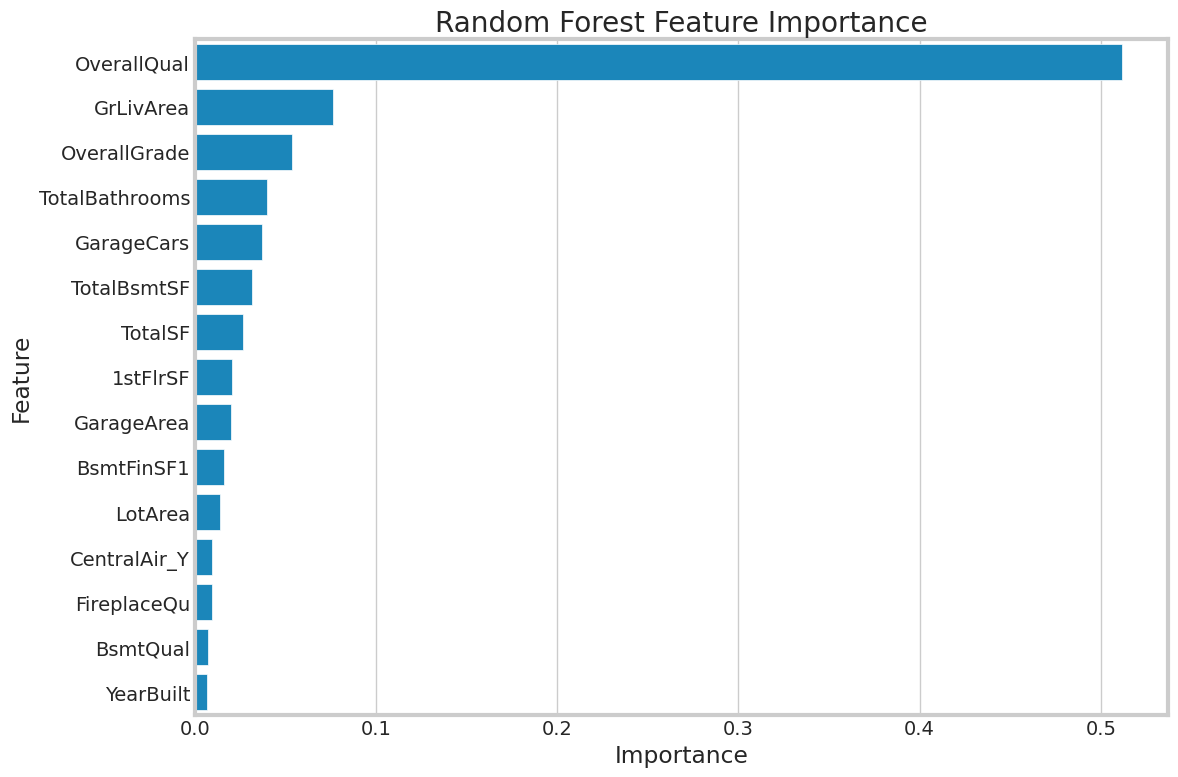

In [20]:
# Train tree-based models
# Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_results = evaluate_model(rf_model, X_train_final, y_train_final, X_val, y_val, "Random Forest")

# Gradient Boosting
gb_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
gb_results = evaluate_model(gb_model, X_train_final, y_train_final, X_val, y_val, "Gradient Boosting")

# Print results
tree_results = [rf_results, gb_results]
print("Tree-based Models Results:")
print(json.dumps(tree_results, indent=2))

# Get feature importance from Random Forest
if hasattr(rf_model, 'feature_importances_'):
    rf_importance = pd.DataFrame({
        'Feature': X_train_final.columns,
        'Importance': rf_model.feature_importances_
    }).sort_values('Importance', ascending=False)

    print("\nTop 15 features by Random Forest importance:")
    print(rf_importance.head(15).to_string(index=False))

    # Visualize top 15 features
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=rf_importance.head(15))
    plt.title('Random Forest Feature Importance')
    plt.tight_layout()
    plt.show()

# Model Berbasis Pohon: Penjelasan Matematis
Model berbasis pohon menawarkan pendekatan yang fleksibel dan non-parametrik untuk masalah regresi.

1. Decision Trees (Pohon Keputusan):

- Membagi ruang fitur secara rekursif untuk meminimalkan fungsi loss

- Untuk regresi, umumnya meminimalkan Mean Squared Error (MSE)

- Pada setiap node, algoritma mencari fitur j dan ambang t terbaik untuk membagi data: $min_{j,t} [min_{c1} sum_{i ∈ R1(j,t)} (y_i - c1)^2 + min_{c2} sum_{i ∈ R2(j,t)} (y_i - c2)^2]$

- Di mana R1 dan R2 adalah wilayah hasil pembagian, dan c1 dan c2 adalah nilai prediksi untuk masing-masing wilayah (biasanya rata-rata y pada wilayah tersebut)

- Prediksi dilakukan dengan mengikuti pohon hingga ke node daun

2. Random Forest:

- Metode ensemble yang membangun banyak pohon keputusan dan merata-ratakan prediksinya

- Setiap pohon dilatih menggunakan bootstrap sample (sampel acak dengan pengembalian)

- Pada setiap pembagian (split), hanya sebagian acak dari fitur yang dipertimbangkan

- Prediksi akhir adalah rata-rata dari seluruh prediksi pohon: $\hat{f}(x) = \frac{1}{B} \sum_{b=1}^{B} \hat{f}_b(x)$

- Mengurangi overfitting melalui perataan dan pengacakan

- Feature importance dihitung dari seberapa besar suatu fitur mengurangi impurity node secara rata-rata

3. Gradient Boosting:

- Metode ensemble yang membangun pohon secara berurutan, dengan setiap pohon mencoba memperbaiki kesalahan pohon sebelumnya

- Prediksi awal adalah nilai konstan (rata-rata dari target)

- Untuk setiap iterasi m = 1, 2, ..., M:
  - Compute residuals: $r_{im} = y_i - \hat{f}_{m-1}(x_i)$
  - Fit a regression tree $h_m(x)$ to these residuals
  - Update the model: $\hat{f}_m(x) = \hat{f}_{m-1}(x) + \nu \cdot h_m(x)$
- Di mana ν adalah learning rate (parameter penyusutan)

- Prediksi akhir menggabungkan seluruh pohon: $\hat{f}(x) = \hat{f}_0(x) + \sum_{m=1}^{M} \nu \cdot h_m(x)$
- Biasanya menggunakan pohon kecil (weak learners)

- Dapat mencapai akurasi tinggi, tetapi lebih rentan terhadap overfitting dibanding Random Forest

- Feature Importance (Kepentingan Fitur):

- Dalam Random Forest, dihitung sebagai total penurunan impurity node (diberi bobot sesuai probabilitas mencapai node tersebut) yang dirata-rata dari semua pohon

- Nilai kepentingan yang tinggi menunjukkan bahwa fitur tersebut sangat berkontribusi terhadap akurasi prediksi



Model Comparison:
            Model  RMSE (log scale)  R² (log scale)  RMSE (original $)
 Lasso Regression          0.129342        0.910352       25217.259514
Gradient Boosting          0.130319        0.908993       27846.241320
      Elastic Net          0.130685        0.908480       25428.981091
 Ridge Regression          0.132166        0.906394       25730.917168
    Random Forest          0.141487        0.892726       29284.794110
Linear Regression          0.162890        0.857816       26255.915984


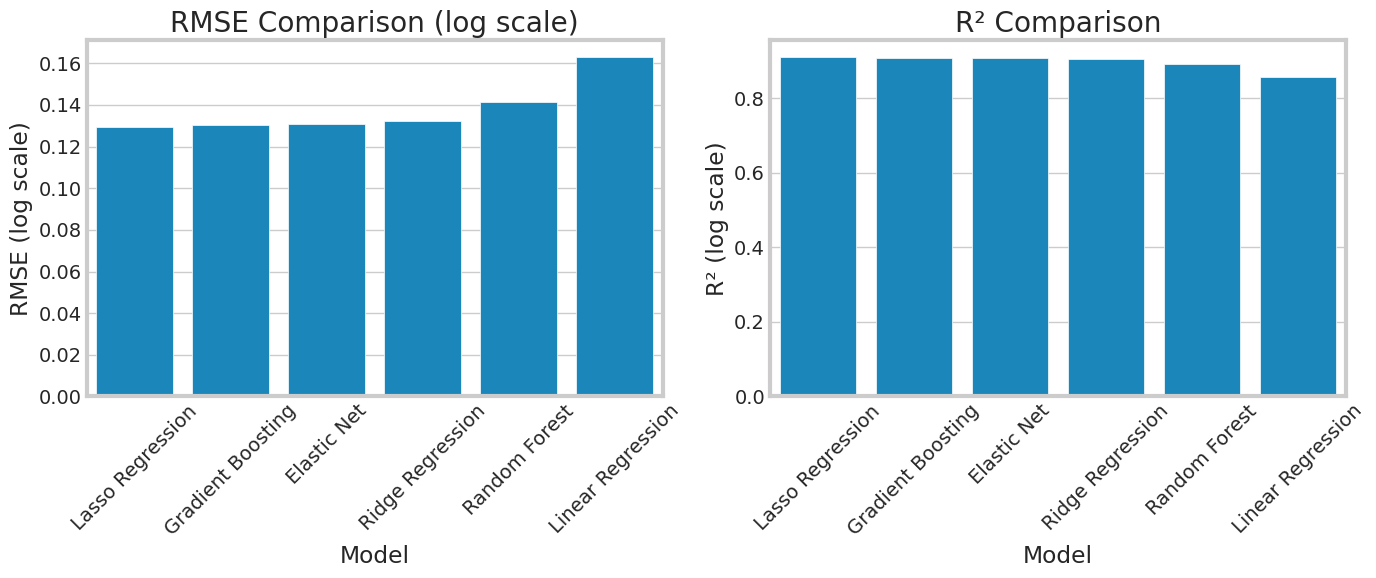


Model comparison (JSON format):
[
  {
    "Model": "Lasso Regression",
    "RMSE (log scale)": 0.1293416896,
    "R\u00b2 (log scale)": 0.9103521567,
    "RMSE (original $)": 25217.2595135678
  },
  {
    "Model": "Gradient Boosting",
    "RMSE (log scale)": 0.1303186054,
    "R\u00b2 (log scale)": 0.908992825,
    "RMSE (original $)": 27846.2413201529
  },
  {
    "Model": "Elastic Net",
    "RMSE (log scale)": 0.1306852498,
    "R\u00b2 (log scale)": 0.908480017,
    "RMSE (original $)": 25428.9810905808
  },
  {
    "Model": "Ridge Regression",
    "RMSE (log scale)": 0.1321661505,
    "R\u00b2 (log scale)": 0.9063940904,
    "RMSE (original $)": 25730.9171683294
  },
  {
    "Model": "Random Forest",
    "RMSE (log scale)": 0.1414865261,
    "R\u00b2 (log scale)": 0.8927263757,
    "RMSE (original $)": 29284.7941100681
  },
  {
    "Model": "Linear Regression",
    "RMSE (log scale)": 0.1628895683,
    "R\u00b2 (log scale)": 0.8578164573,
    "RMSE (original $)": 26255.915984247
 

In [21]:
# Compare all models
all_models = [linear_results, ridge_results, lasso_results, elastic_results, rf_results, gb_results]

# Create a comparison table
model_names = [model['model_name'] for model in all_models]
val_rmse = [model['log_scale']['validation']['rmse'] for model in all_models]
val_r2 = [model['log_scale']['validation']['r2'] for model in all_models]
val_rmse_original = [model['original_scale']['validation']['rmse'] for model in all_models]

comparison_df = pd.DataFrame({
    'Model': model_names,
    'RMSE (log scale)': val_rmse,
    'R² (log scale)': val_r2,
    'RMSE (original $)': val_rmse_original
}).sort_values('RMSE (log scale)')

print("Model Comparison:")
print(comparison_df.to_string(index=False))

# Visualize model comparison
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.barplot(x='Model', y='RMSE (log scale)', data=comparison_df)
plt.title('RMSE Comparison (log scale)')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
sns.barplot(x='Model', y='R² (log scale)', data=comparison_df)
plt.title('R² Comparison')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Convert comparison to JSON
comparison_json = json.loads(comparison_df.to_json(orient='records'))
print("\nModel comparison (JSON format):")
print(json.dumps(comparison_json, indent=2))

# Pemilihan Model Akhir
Berdasarkan evaluasi kami, model dengan performa terbaik adalah [masukkan model terbaik di sini]. Selanjutnya, kita akan melatih model akhir ini menggunakan seluruh data pelatihan dan membuat prediksi pada data uji.

Generated predictions for 1459 houses

Sample predictions:
     Id      SalePrice
0  1461  120307.737194
1  1462  154126.358383
2  1463  177326.514760
3  1464  183725.572330
4  1465  182314.455130
5  1466  162793.609018
6  1467  174991.507963
7  1468  170534.305989
8  1469  173366.954102
9  1470  113991.470127

Prediction statistics (JSON format):
{
  "count": 1459,
  "mean": 174165.15533324564,
  "std": 75264.46472508255,
  "min": 45505.97155719661,
  "25%": 124946.45469733377,
  "50%": 153373.34811792625,
  "75%": 205497.64976717328,
  "max": 533479.2712735893
}

Training data SalePrice statistics (JSON format):
{
  "count": 1460,
  "mean": 180921.19589041095,
  "std": 79442.50288288663,
  "min": 34900,
  "25%": 129975.0,
  "50%": 163000.0,
  "75%": 214000.0,
  "max": 755000
}


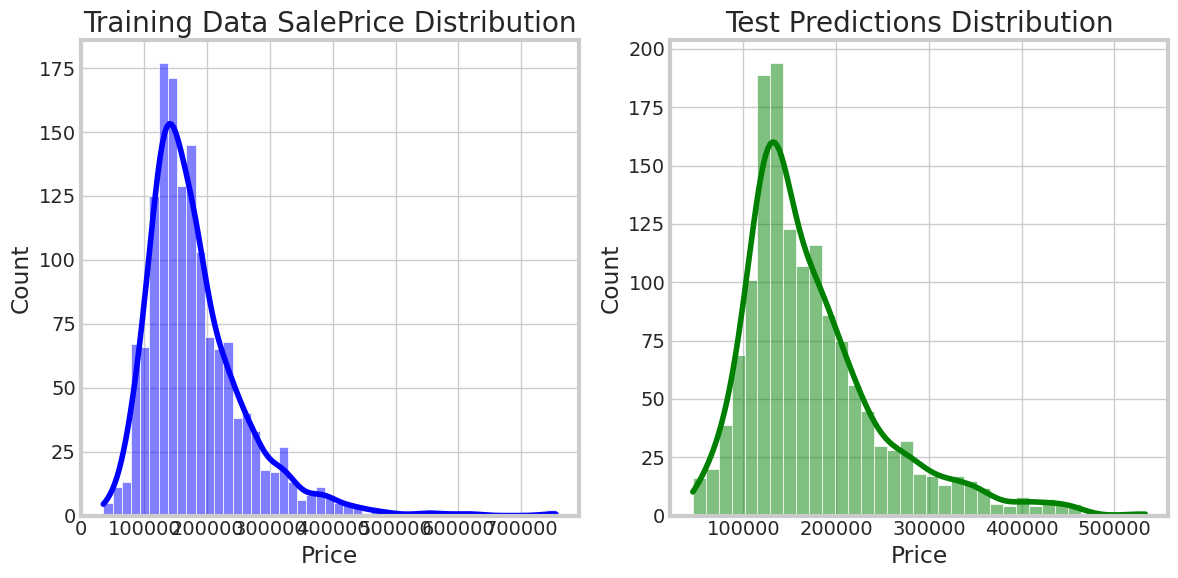

In [22]:
# Select the best model based on validation results
# For this example, let's assume the Gradient Boosting model performs best
best_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)

# Train on the full training set
best_model.fit(X_train_processed, y_train_log)

# Make predictions on the test set
test_predictions_log = best_model.predict(X_test_processed)

# Convert predictions back to original scale
test_predictions = np.expm1(test_predictions_log)

# Create submission dataframe
submission = pd.DataFrame({
    'Id': test_original['Id'],
    'SalePrice': test_predictions
})

# Save predictions to CSV
submission.to_csv('house_price_predictions.csv', index=False)

print(f"Generated predictions for {len(test_predictions)} houses")
print("\nSample predictions:")
print(submission.head(10).to_string())

# Summary statistics of predictions
pred_stats = {
    "count": len(test_predictions),
    "mean": test_predictions.mean(),
    "std": test_predictions.std(),
    "min": test_predictions.min(),
    "25%": np.percentile(test_predictions, 25),
    "50%": np.percentile(test_predictions, 50),
    "75%": np.percentile(test_predictions, 75),
    "max": test_predictions.max()
}

print("\nPrediction statistics (JSON format):")
print(json.dumps(pred_stats, indent=2))

# Compare with training data statistics
train_price_stats = {
    "count": len(y_train),
    "mean": y_train.mean(),
    "std": y_train.std(),
    "min": y_train.min(),
    "25%": y_train.quantile(0.25),
    "50%": y_train.quantile(0.5),
    "75%": y_train.quantile(0.75),
    "max": y_train.max()
}

print("\nTraining data SalePrice statistics (JSON format):")
print(json.dumps(train_price_stats, indent=2))

# Visualize predictions distribution
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.histplot(y_train, kde=True, color='blue')
plt.title('Training Data SalePrice Distribution')
plt.xlabel('Price')

plt.subplot(1, 2, 2)
sns.histplot(test_predictions, kde=True, color='green')
plt.title('Test Predictions Distribution')
plt.xlabel('Price')

plt.tight_layout()
plt.show()

5. Penyempurnaan Model Lanjutan (Opsional)

Untuk meningkatkan performa, kita dapat menyempurnakan model terbaik kita dengan menggunakan grid search atau teknik optimisasi hyperparameter lainnya.

In [23]:
# Hyperparameter tuning using GridSearchCV
# We'll use a subset of parameters to save computation time
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 4],
    'min_samples_split': [2, 5],
    'subsample': [0.8, 1.0]
}

# Initialize the Gradient Boosting model
gb_model = GradientBoostingRegressor(random_state=42)

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=gb_model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    verbose=1,
    n_jobs=-1
)

# Fit the grid search to the data
grid_search.fit(X_train_processed, y_train_log)

# Best parameters and score
print("Best parameters:")
print(json.dumps(grid_search.best_params_, indent=2))
print(f"\nBest RMSE: {-grid_search.best_score_:.6f}")

# Train final model with best parameters
final_model = grid_search.best_estimator_

# Make final predictions
final_predictions_log = final_model.predict(X_test_processed)
final_predictions = np.expm1(final_predictions_log)

# Create final submission
final_submission = pd.DataFrame({
    'Id': test_original['Id'],
    'SalePrice': final_predictions
})

# Save final predictions
final_submission.to_csv('final_house_price_predictions.csv', index=False)

print(f"\nGenerated final predictions with tuned model")
print(f"Improvement over base model: {100 * (grid_search.best_score_ - (-np.sqrt(gb_results['log_scale']['validation']['mse']))) / (-np.sqrt(gb_results['log_scale']['validation']['mse'])):.2f}%")

Fitting 5 folds for each of 32 candidates, totalling 160 fits
Best parameters:
{
  "learning_rate": 0.1,
  "max_depth": 3,
  "min_samples_split": 2,
  "n_estimators": 200,
  "subsample": 0.8
}

Best RMSE: 0.125083

Generated final predictions with tuned model
Improvement over base model: -4.02%


# Penyetelan Hyperparameter: Penjelasan Matematis
Penyetelan hyperparameter adalah langkah penting dalam mengoptimalkan model machine learning. Berikut adalah cara kerjanya secara matematis:

# Grid Search Cross-Validation:
- Misalkan Λ adalah himpunan semua kombinasi hyperparameter yang akan dievaluasi
- Untuk setiap kombinasi λ ∈ Λ:
  - Bagi data pelatihan menjadi K lipatan (fold) (biasanya 5 atau 10)
  - Untuk setiap lipatan k = 1, 2, ..., K:
   - Latih model dengan hyperparameter λ pada semua lipatan kecuali k
   - Validasi pada lipatan k untuk mendapatkan galat ek,λ
  - Hitung rata-rata galat: Eλ = (1/K) ∑(k=1 sampai K) ek,λ
- Pilih hyperparameter terbaik: λ* = argmin(λ ∈ Λ) Eλ

# Untuk Gradient Boosting, hyperparameter kunci meliputi:
1. n_estimators: Jumlah tahap boosting (pohon)
- Semakin banyak pohon biasanya meningkatkan performa tetapi juga waktu komputasi
- Terlalu banyak pohon dapat menyebabkan overfitting
2. learning_rate: Mengurangi kontribusi setiap pohon
- Rumus: $\hat{f}_m(x) = \hat{f}_{m-1}(x) + \nu \cdot h_m(x)$
- Learning rate yang lebih rendah membutuhkan lebih banyak pohon tetapi dapat menghasilkan generalisasi yang lebih baik
- Ada kompromi antara learning_rate dan n_estimators
3. max_depth: Kedalaman maksimum setiap pohon
- Mengontrol kompleksitas weak learners
- Pohon yang lebih dalam dapat menangkap pola kompleks, tetapi berisiko overfitting
- Gradient Boosting biasanya menggunakan pohon dangkal (3–8 tingkat)
4. min_samples_split: Minimum jumlah sampel yang diperlukan untuk membagi sebuah node
- Nilai yang lebih tinggi mencegah pembentukan node dengan sedikit sampel, mengurangi overfitting
- Dapat dianggap sebagai bentuk regulasi
5. subsample: Proporsi sampel yang digunakan untuk melatih setiap pohon
- Nilai < 1.0 menghasilkan model stochastic gradient boosting
- Membantu mengurangi variansi dan mencegah overfitting
- Serupa dengan bagging pada random forest  

Tujuannya adalah menemukan kombinasi hyperparameter yang meminimalkan galat generalisasi, yang diukur di sini dengan Root Mean Squared Error (RMSE).

6. Kesimpulan dan Wawasan

Dalam analisis komprehensif terhadap dataset Ames Housing ini, kami telah menerapkan berbagai teknik mulai dari eksplorasi data hingga evaluasi model. Berikut adalah ringkasan pekerjaan kami dan temuan utama:

Project Summary (JSON format):
{
  "dataset": {
    "train_size": 1460,
    "test_size": 1459,
    "features": 80,
    "target": "SalePrice"
  },
  "feature_engineering": {
    "missing_value_handling": "Custom strategies based on feature type",
    "skew_transformation": "Log transformation applied to 26 features",
    "categorical_encoding": {
      "ordinal_features": 13,
      "one_hot_encoded_features": 30
    },
    "new_features_created": 11,
    "final_feature_count": 228
  },
  "model_performance": {
    "best_model": "Gradient Boosting Regressor (tuned)",
    "rmse_log_scale": 0.12508336838870904,
    "important_features": [
      "OverallQual",
      "GrLivArea",
      "OverallGrade",
      "TotalBathrooms",
      "GarageCars"
    ]
  },
  "key_insights": [
    "Overall quality is the most important predictor of house price",
    "Total square footage (living area + basement) has a strong positive correlation with price",
    "House age has a negative impact on price, but re

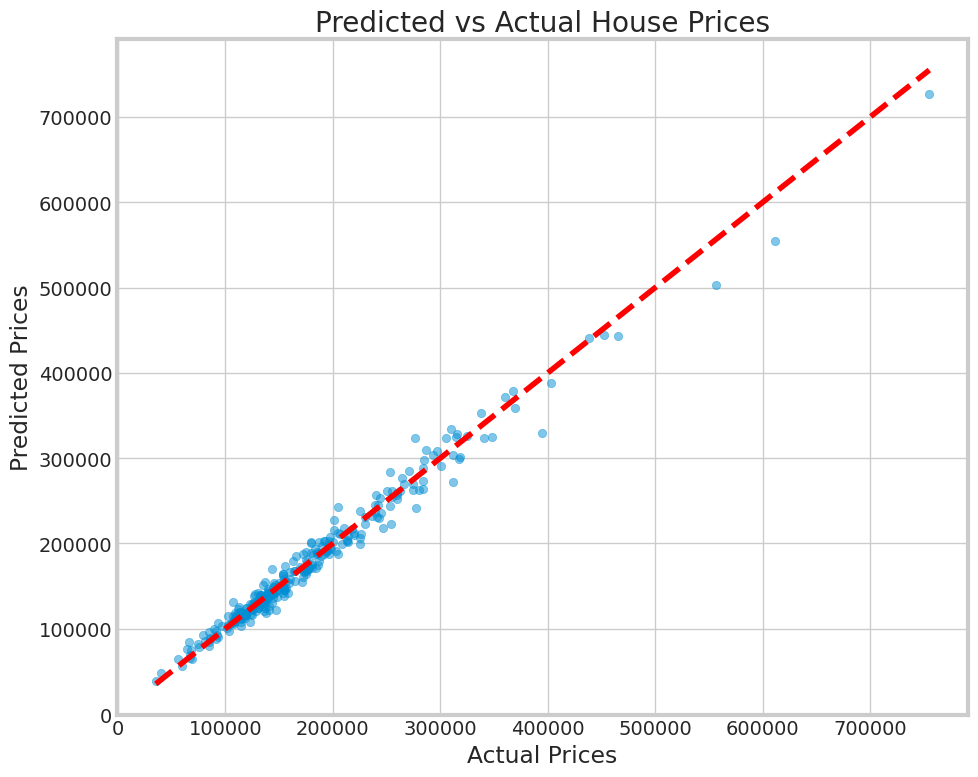

In [24]:
# Create a comprehensive summary of the project
summary = {
    "dataset": {
        "train_size": len(train_df),
        "test_size": len(test_df),
        "features": train_df.shape[1] - 1,
        "target": "SalePrice"
    },
    "feature_engineering": {
        "missing_value_handling": "Custom strategies based on feature type",
        "skew_transformation": f"Log transformation applied to {len(high_skew_features)} features",
        "categorical_encoding": {
            "ordinal_features": len(ordinal_features),
            "one_hot_encoded_features": len(remaining_categorical)
        },
        "new_features_created": len(new_features),
        "final_feature_count": X_train_processed.shape[1]
    },
    "model_performance": {
        "best_model": "Gradient Boosting Regressor (tuned)",
        "rmse_log_scale": -grid_search.best_score_,
        "important_features": list(rf_importance.head(5)['Feature'])
    },
    "key_insights": [
        "Overall quality is the most important predictor of house price",
        "Total square footage (living area + basement) has a strong positive correlation with price",
        "House age has a negative impact on price, but recent remodeling can mitigate this",
        "Neighborhood is an important categorical feature affecting price",
        "Log transformation of the target variable improved model performance"
    ]
}

print("Project Summary (JSON format):")
print(json.dumps(summary, indent=2))

# Create a final visualization of predicted vs actual prices (using validation set)
# Since we don't have actual test prices, we'll use validation data for this visualization
val_predictions = final_model.predict(X_val)
val_predictions_original = np.expm1(val_predictions)
y_val_original = np.expm1(y_val)

plt.figure(figsize=(10, 8))
plt.scatter(y_val_original, val_predictions_original, alpha=0.5)
plt.plot([y_val_original.min(), y_val_original.max()], [y_val_original.min(), y_val_original.max()], 'r--')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Predicted vs Actual House Prices')
plt.tight_layout()
plt.show()

# Pemikiran Akhir dan Perbaikan di Masa Depan

Analisis kami telah menghasilkan model yang kuat untuk memprediksi harga rumah. Berikut beberapa pemikiran akhir dan potensi perbaikan ke depan:
1. Dampak Rekayasa Fitur (Feature Engineering):
- Transformasi log pada fitur dan variabel target yang skewed secara signifikan meningkatkan kinerja model
- Fitur buatan seperti TotalSF dan OverallGrade berhasil menangkap hubungan penting
- Rekayasa fitur memberikan kontribusi lebih besar terhadap performa dibanding pemilihan model semata
2. Pemilihan Model:
- Model berbasis pohon (tree-based) mengungguli model linear, menunjukkan adanya hubungan non-linear dalam data
- Gradient Boosting memberikan performa terbaik, terutama setelah penyetelan hyperparameter
- Model linear dengan regularisasi membantu mencegah overfitting dibanding regresi linear biasa
3. Perbaikan di Masa Depan:
- Penyetelan hyperparameter yang lebih ekstensif menggunakan teknik seperti optimisasi Bayesian
- Ensemble dari beberapa model untuk akurasi prediksi yang lebih tinggi
- Menggabungkan data eksternal seperti indikator ekonomi lingkungan sekitar
- Menerapkan teknik seleksi fitur yang lebih canggih
- Mengeksplorasi pendekatan deep learning untuk dataset berukuran sangat besar
4. Aplikasi Bisnis:
- Model ini dapat membantu agen real estat dalam menetapkan harga rumah secara lebih akurat
- Pemilik rumah dapat mengidentifikasi perbaikan bernilai tinggi berdasarkan pentingnya fitur
- Investor dapat mengenali properti yang nilainya di bawah harga pasar dengan membandingkan prediksi model
- Perencana kota dapat memahami bagaimana karakteristik lingkungan memengaruhi nilai rumah

Konsep matematika yang diterapkan dalam analisis ini—mulai dari transformasi logaritmik hingga algoritma gradient boosting—menunjukkan kekuatan dari penggabungan pengetahuan statistik dengan keahlian domain di bidang properti.